# Bycicle Location

In [2]:
# Import

import numpy as np
import ujson
import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle

# Multi Criteria Decision Making

from skcriteria import Data, MIN, MAX
import itertools
from skcriteria.madm.moora import norm, rank
from skcriteria.madm.moora import *

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

# Part 1: Readind solutions from files

In [3]:
matrix_rango = pd.read_csv('tif_files/matrix_rango.csv', sep=';').to_numpy()
locations = pd.read_csv('tif_files/locations_with_id.csv', sep=';').to_numpy()

# Part 2: AHP

In [4]:
# Criteria
# Urban Life, User, Transport
categories = np.array([[1, 1, 1/3],
                       [1, 1, 1/2],
                       [3, 2, 1]])

# Sub criteria
# Green Areas, Tourism, Mall, Sport Centres
urban = np.array([[1,   3,   5,   2],
                  [1/3, 1,   1,   1/3],
                  [1/5, 1,   1,   1/3],
                  [1/2, 3,   3,   1]])
                 
# Density, School, Universities
user = np.array([[1,   4,   1/3],
                 [1/4, 1,   1/5],
                 [3,   5,    1]])

# Bike Lane, Bus Stop
transport = np.array([[1,   2],
                      [1/2, 1]]) 

w_c = (categories/categories.sum(axis = 0)).mean(axis = 1)

w_b = (urban/urban.sum(axis = 0)).mean(axis = 1)
w_u = (user/user.sum(axis = 0)).mean(axis = 1)
w_t = (transport/transport.sum(axis = 0)).mean(axis = 1)

# Obtain final weight of sub criteria 
w_bf = w_b * w_c[0]   # Urban sub criteria
w_uf = w_u * w_c[1]   # User sub criteria
w_tf = w_t * w_c[2]   # Transport sub criteria

print(w_bf)
print(w_uf)
print(w_tf)

# Metrics AHP

# Transport doesn't have metrics because there are 2 cols.

eig_c = np.linalg.eigvals(categories).max()
eig_b = np.linalg.eigvals(urban).max()
eig_u = np.linalg.eigvals(user).max()

eig_values = np.array([eig_c, eig_b, eig_u])
print('Eigen Values')
print(eig_values)

print('Metric CI')
CI  = (eig_values-np.array([categories.shape[0], urban.shape[0], user.shape[0]]))/np.array([categories.shape[0]-1, urban.shape[0]-1, user.shape[0]-1])
print(*CI)

print('Metric RI')
RI = np.array([0.58, 0.90, 0.58]) # Obtained from table
print(*RI)

print('Metric CR')
CR = CI/RI
print(*CR)

w = np.concatenate((w_tf, [w_uf[0]], [w_bf[0]], [w_bf[2]], [w_uf[1]], [w_bf[3]], [w_bf[1]], [w_uf[2]]))
w

[0.10068327 0.02526449 0.02181193 0.06284637]
[0.06847322 0.02322832 0.14920755]
[0.36565657 0.18282828]
Eigen Values
[3.01829471+0.j 4.04880192+0.j 3.08576669+0.j]
Metric CI
(0.009147353644816558+0j) (0.01626730731881783+0j) (0.042883345628599745+0j)
Metric RI
0.58 0.9 0.58
Metric CR
(0.015771299387614755+0j) (0.01807478590979759+0j) (0.0739368028079306+0j)


array([0.36565657, 0.18282828, 0.06847322, 0.10068327, 0.02181193,
       0.02322832, 0.06284637, 0.02526449, 0.14920755])

# Part 3: MCDM

In [5]:
matrix_rango_after = matrix_rango[:][:,1:10] 
matrix_rango_after = matrix_rango_after.astype(float)

In [6]:
matrix_rango_pond_sqr = np.square(matrix_rango_after)
matrix_rango_pond_den = np.sqrt(np.sum(matrix_rango_pond_sqr, axis = 0, keepdims = True))

matrix = matrix_rango_after / matrix_rango_pond_den
y = np.sum(matrix * w, axis = 1, keepdims = True)

matrix_df = pd.DataFrame(y)

# El orden_1 esta ordenado de mejor a peor solución según RS.
# El ord_1 tiene el valor de ranking que toma cada solucion
# El ord_1_by_lib tiene el valor de ranking que toma cada solucion pero obtenido a traves de la libreria

#orden_1 = np.argsort(y.ravel())[::-1]
orden_1 = matrix_df.sort_values(0, ascending = False).index

ord_1 = np.zeros(len(orden_1))
for i in range(len(orden_1)):
    ord_1[orden_1[i]] = i+1

In [7]:
vector_rango_max = np.max(matrix, axis = 0)
matrix_rango_rf =  vector_rango_max*w - matrix*w
y_ref = np.max(matrix_rango_rf, axis = 1, keepdims=True)
matrix_ref = pd.DataFrame(y_ref)
orden_2 = matrix_ref.sort_values(0, ascending = True).index

ord_2 = np.zeros(len(orden_2))
for i in range(len(orden_2)):
    ord_2[orden_2[i]] = i+1

In [8]:
y_m = np.prod(matrix_rango_after, axis = 1, keepdims=True)
matrix_m = pd.DataFrame(y_m)
orden_3 = matrix_m.sort_values(0, ascending = False).index

ord_3 = np.zeros(len(orden_3))
for i in range(len(orden_3)):
    ord_3[orden_3[i]] = i+1

In [9]:
ratio_rank = ord_1
refpoint_rank = ord_2
fmf_rank = ord_3

rank_mtx = np.vstack((ratio_rank, refpoint_rank, fmf_rank)).T

alternatives = rank_mtx.shape[0]
points = np.zeros(alternatives)
for idx0, idx1 in itertools.combinations(range(alternatives), 2):
    alt0, alt1 = rank_mtx[idx0], rank_mtx[idx1]
    dom = rank.dominance(alt0, alt1)
    dom_idx = idx0 if dom > 0 else idx1
    points[dom_idx] += 1

rank_mm = rank.rankdata(points, reverse=True)  # rank multimoora

Best Station

In [10]:
np.argwhere(rank_mtx[:,1] == 1) # mejor estacion

array([[353]], dtype=int64)

Multimoora

In [11]:
alternativa = np.array(range(alternatives)).reshape(-1,1)
first_20 = rank_mm.reshape(-1,1)
first_20_2 = rank_mtx

table = np.concatenate((alternativa, first_20_2, first_20), axis = 1)
table_df = pd.DataFrame(table, dtype=int)
table_df.columns = ['alternativas','ratio','ref','form','multimoora']
table_df = table_df.sort_values('multimoora',ascending=True)
#table_df.to_csv("multi_20.csv",sep=';')
print(table_df)

     alternativas  ratio  ref  form  multimoora
32             32      1   63     1           1
30             30      2   46     2           2
101           101      4   27     3           3
31             31      3   55     5           4
33             33      5   68     4           5
..            ...    ...  ...   ...         ...
562           562    611  611   611         611
563           563    613  612   612         612
564           564    612  613   613         613
565           565    614  614   614         614
566           566    615  615   615         615

[615 rows x 5 columns]


# Part 4: Results

In [12]:
# Método 1
import pickle

Aloc = pickle.load(open("Data/dist_among_location.p","rb"))
dist = np.empty((615,615))
for i in range(615):
    for j in range(615):
        dist[i,j] = Aloc[i*615 + j][1]
        

#Aloc_2 = pd.read_csv('tif_files/dist_entre_loc.csv', sep = ';')
#dist_2 = Aloc_2.iloc[:,2:].to_numpy()

In [13]:
table_df['alternativas']

res = []
for i in table_df['alternativas']:
    if len(res) == 0:
        res.append(i)
        
    else:
        if (dist[res,i] > 250).all():    # Cambiar si se quiere usar dist o dist_2
            res.append(i)
                
        else:
            continue

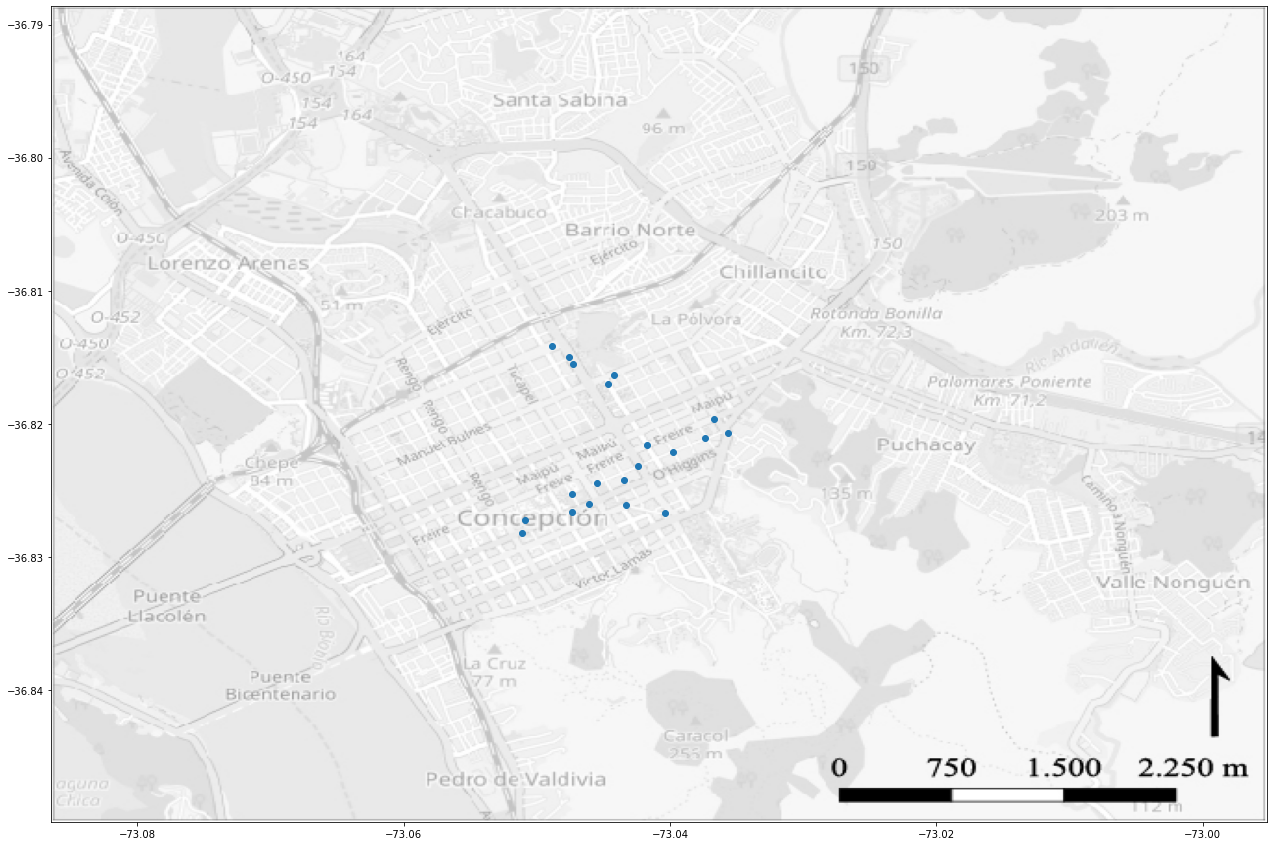

In [14]:
num_stations = 20

solucion_final = locations[res[:num_stations]]
#solucion_final = locations[[187]]

import matplotlib.cbook as cbook

plt.figure(figsize = (25,15))
datafile = cbook.get_sample_data("C:\\Users\\Hugo\\Desktop\\Paper Bike\\bike_sharing_code\\map2.jpg")
img = plt.imread(datafile)
#plt.scatter(x,y,zorder=1)
plt.imshow(img, zorder=0, extent=[-73.08647, -72.9952, -36.84988, -36.78864])
plt.scatter(x = solucion_final[:,1], y = solucion_final[:,2])
plt.show()

In [15]:
sol_df = pd.DataFrame(locations[res[:num_stations]])
sol_df.columns = ['point_id','X','Y']
sol_df.to_csv("solucion_" + str(num_stations) + "_mcdm_paper.csv",sep=';')

Calculating the percentage covered

In [16]:
# Calcular cobertura

A = pd.read_csv('tif_files/dist_entre_loc_dem.csv', sep = ';')   #filas 1295, columnas 615

A = A.iloc[:,2:].values.T  #filas 615, columnas 1295
A.shape   

(615, 1295)

In [17]:
demData = pd.read_excel('Data/Demands.xlsx')
demData = demData[['SHOPS', 'EDUCATION', 'BUS_STOPS', 'HOUSES']]

In [18]:
indices = np.argwhere(A[res[:num_stations]] < 250)
puntos_de_demanda = np.unique(indices[:,1])

In [19]:
demData.iloc[puntos_de_demanda,:].sum()

SHOPS        0.357931
EDUCATION    0.653643
BUS_STOPS    0.331952
HOUSES       0.114543
dtype: float64

# Calculating objective functions for the solution

In [20]:
Pvalue = num_stations

RobustPonds = json.load(open(f'results_{num_stations}_b/RobustLocDemand1.json'))
Aloc = pickle.load(open("Data/dist_among_location.p","rb"))
demLen = 1295
locLen = 615

def functionRobust(pop):
    robustdemands = [RobustPonds[str(i)]['Min'] if i in pop else RobustPonds[str(i)]['Max'] for i in range(locLen)]   
    fitness = sum(sorted(robustdemands, reverse=True)[:Pvalue]) - sum([robustdemands[i] for i in pop])
    return fitness

def functionLocDist(pop):
    fitness = 9999999999
    for i in pop:
        for j in pop:
            if(i!=j and Aloc[j*locLen+i][1] < fitness):
                fitness = Aloc[j*locLen+i][1]
    return fitness

In [21]:
pop = res[:num_stations]
robustdemands = [RobustPonds[str(i)]['Min'] if i in pop else RobustPonds[str(i)]['Max'] for i in range(locLen)]
fitness = sum(sorted(robustdemands, reverse=True)[:Pvalue]) - sum([robustdemands[i] for i in pop])
fitness

0.5051922284887878

In [22]:
functionRobust(res[:num_stations])

0.5051922284887878

In [23]:
functionLocDist(res[:num_stations])

252.51687215976168